# Homework 2: Discovery of Frequent Itemsets and Association Rules

**Course:** ID2222 Data Mining (KTH Royal Institute of Technology)  
**Authors:** Marco Cecilia, Stefano Romano
**Date:** 13/11/2025

---

### 🎯 Objective
This notebook implements the **A-Priori algorithm** to find **frequent itemsets** and (optionally) to generate **association rules**.

We will:
1. Load a dataset of transactions 
2. Implement the A-Priori algorithm using **pandas**
3. Find all frequent itemsets with support ≥ *s*
4. (Bonus) Generate association rules with confidence ≥ *c*

---

### 📂 Dataset

We use the synthetic market-basket dataset `T10I4D100K.dat` provided in the course:

- Each **row** corresponds to a **basket / transaction**.
- Each row contains **integer item IDs** separated by spaces.
- The dataset contains **100,000 transactions**.

---


In [1]:
import pandas as pd
import itertools
from collections import defaultdict
import matplotlib.pyplot as plt
import time

## 1. Loading and Inspecting the Transaction Dataset

In this section we:

- Read the raw transaction file `T10I4D100K.dat`.
- Parse each line into a list of integer item IDs.
- Store the transactions in a pandas `DataFrame` for convenience.

Each transaction is represented as:

- `TransactionID`: an integer index (1, 2, 3, …),
- `Items`: a Python `list` containing all items in that basket.


In [2]:
# Path to dataset (you will upload it in VS Code / GitHub)
file_path = "data/T10I4D100K.dat"

# Each line = one transaction, items separated by spaces
transactions = []
with open(file_path, "r") as f:
    for line in f:
        items = list(map(int, line.strip().split()))
        transactions.append(items)

# Convert into a pandas DataFrame
df = pd.DataFrame({"TransactionID": range(1, len(transactions) + 1), "Items": transactions})

df.head()

# dimensions of the dataset
num_transactions = df.shape[0]
print(f"Number of transactions: {num_transactions}")

Number of transactions: 100000


## 2. Support and Confidence Thresholds

We now define the key hyperparameters:

- **Minimum support** `min_support`  
  - Defined here as an **absolute count** (number of transactions).  
  - Example: with 100,000 transactions, a support of 1,000 corresponds to 1% of all transactions.

- **Minimum confidence** `min_confidence`  
  - Used in the **association rule generation** step.  
  - A rule `X → Y` has confidence:
    \[
    \text{conf}(X \to Y) = \frac{\text{support}(X \cup Y)}{\text{support}(X)}
    \]


In [3]:
# Minimum support (as an absolute count)
# Let's start with a threshold that gives interpretable results without overloading memory.
# The dataset has 100,000 transactions, so 0.5% = 500 transactions.
min_support = 1000

# Minimum confidence for association rules (between 0 and 1)
min_confidence = 0.6

print(f"Minimum Support: {min_support}")
print(f"Minimum Confidence: {min_confidence}")


Minimum Support: 1000
Minimum Confidence: 0.6


## 3. Implementing the A-Priori Algorithm

We now implement the **A-Priori algorithm** as described in:

- Lecture 3 *Frequent Itemsets*,
- R. Agrawal and R. Srikant, *Fast Algorithms for Mining Association Rules*, VLDB '94.

Key ideas:

- The **downward closure property** (monotonicity of support):  
  > If an itemset is frequent, then all its subsets are also frequent.
- The algorithm proceeds level-wise:
  1. Find all **frequent 1-itemsets** \(L_1\).
  2. Generate **candidate k-itemsets** \(C_k\) from \(L_{k-1}\).
  3. Count supports of candidates in one pass over the data.
  4. Filter candidates with support ≥ `min_support` to obtain \(L_k\).
  5. Repeat until no more frequent itemsets are found.


In [4]:
def get_frequent_itemsets(transactions, min_support):
    """Run the Apriori algorithm to find all frequent itemsets
    with support (absolute count) >= min_support.

    Parameters
    ----------
    transactions : list[list[hashable]]
        List of baskets, each basket is a list of items.
    min_support : int
        Minimum support as an absolute number of transactions.

    Returns
    -------
    dict[frozenset, int]
        Dictionary mapping each frequent itemset (as a frozenset)
        to its support count.
    """
    # -------- Pass 1: count single items (L1) --------
    item_counts = defaultdict(int)
    for transaction in transactions:
        for item in transaction:
            item_counts[frozenset([item])] += 1

    # Keep only items that are frequent
    L1 = {itemset: count for itemset, count in item_counts.items()
          if count >= min_support}

    # This dictionary will store ALL frequent itemsets of any size
    all_frequent = dict(L1)

    # Current list of (k-1)-item frequent itemsets
    current_Lk = list(L1.keys())
    k = 2  # we already handled 1-itemsets

    # -------- Passes k = 2, 3, ... --------
    while current_Lk:
        # ---- 1) Candidate generation Ck from L(k-1) ----
        candidates = set()
        current_Lk_sorted = [tuple(sorted(itemset)) for itemset in current_Lk]
        n = len(current_Lk_sorted)

        # Join step: combine itemsets that share the first k-2 items
        for i in range(n):
            for j in range(i + 1, n):
                a = current_Lk_sorted[i]
                b = current_Lk_sorted[j]
                # Check if first k-2 items are the same
                if a[:k-2] == b[:k-2]:
                    candidate = frozenset(a).union(b)
                    if len(candidate) == k:
                        candidates.add(candidate)

        # Prune step: remove candidates with an infrequent (k-1)-subset
        Lk_minus_1 = set(current_Lk)  # for quick lookup
        pruned_candidates = set()
        for cand in candidates:
            all_subsets_frequent = True
            for subset in itertools.combinations(cand, k - 1):
                if frozenset(subset) not in Lk_minus_1:
                    all_subsets_frequent = False
                    break
            if all_subsets_frequent:
                pruned_candidates.add(cand)

        if not pruned_candidates:
            break

        # ---- 2) Count support for candidates in one pass over the data ----
        candidate_counts = defaultdict(int)
        for transaction in transactions:
            tset = set(transaction)
            for candidate in pruned_candidates:
                if candidate.issubset(tset):
                    candidate_counts[candidate] += 1

        # Keep only frequent k-itemsets
        Lk = {itemset: count for itemset, count in candidate_counts.items()
              if count >= min_support}

        # If none of the candidates are frequent, stop
        if not Lk:
            break

        # Add to global dictionary and move to next iteration
        all_frequent.update(Lk)
        current_Lk = list(Lk.keys())
        k += 1

    return all_frequent


## 4. Running A-Priori and Inspecting Frequent Itemsets

We can now run the A-Priori algorithm on the full dataset using the
support threshold defined above.

We will:

- Compute all frequent itemsets.
- Print how many frequent itemsets we found.
- Inspect a few of the most frequent itemsets (with the highest support).

In [5]:
frequent_itemsets = get_frequent_itemsets(transactions, min_support)

print(f"Number of frequent itemsets found: {len(frequent_itemsets)}")

# Show first 10 frequent itemsets (arbitrary order)
for itemset, support in list(frequent_itemsets.items())[:10]:
    print(f"Itemset: {set(itemset)}, Support: {support}")


Number of frequent itemsets found: 385
Itemset: {25}, Support: 1395
Itemset: {52}, Support: 1983
Itemset: {240}, Support: 1399
Itemset: {274}, Support: 2628
Itemset: {368}, Support: 7828
Itemset: {448}, Support: 1370
Itemset: {538}, Support: 3982
Itemset: {561}, Support: 2783
Itemset: {630}, Support: 1523
Itemset: {687}, Support: 1762


In [12]:
# Group frequent itemsets by their size (k)
frequent_itemsets_by_k = defaultdict(list)
for itemset, support in frequent_itemsets.items():
    k = len(itemset)
    frequent_itemsets_by_k[k].append((itemset, support))

# Print the number of frequent itemsets and the first 5 itemsets for each k
for k in range(1, 6):
    itemsets_k = frequent_itemsets_by_k[k]
    print(f"Number of frequent {k}-itemsets: {len(itemsets_k)}")
    print(f"First 5 frequent {k}-itemsets:")
    for itemset, support in itemsets_k[:5]:
        print(f"  Itemset: {set(itemset)}, Support: {support}")
    print()

Number of frequent 1-itemsets: 375
First 5 frequent 1-itemsets:
  Itemset: {25}, Support: 1395
  Itemset: {52}, Support: 1983
  Itemset: {240}, Support: 1399
  Itemset: {274}, Support: 2628
  Itemset: {368}, Support: 7828

Number of frequent 2-itemsets: 9
First 5 frequent 2-itemsets:
  Itemset: {704, 825}, Support: 1102
  Itemset: {704, 39}, Support: 1107
  Itemset: {825, 39}, Support: 1187
  Itemset: {227, 390}, Support: 1049
  Itemset: {829, 789}, Support: 1194

Number of frequent 3-itemsets: 1
First 5 frequent 3-itemsets:
  Itemset: {704, 825, 39}, Support: 1035

Number of frequent 4-itemsets: 0
First 5 frequent 4-itemsets:

Number of frequent 5-itemsets: 0
First 5 frequent 5-itemsets:



In [6]:
freq_df = pd.DataFrame(
    [(tuple(itemset), support) for itemset, support in frequent_itemsets.items()],
    columns=["Itemset", "Support"]
)

freq_df_sorted = freq_df.sort_values(by="Support", ascending=False)
display(freq_df_sorted.head(10))


,Itemset,Support
4,"(368,)",7828
50,"(529,)",7057
178,"(829,)",6810
37,"(766,)",6265
124,"(722,)",5845
169,"(354,)",5835
171,"(684,)",5408
73,"(217,)",5375
195,"(494,)",5102
122,"(419,)",5057


## 5. Effect of the Support Threshold

To better understand the behaviour of the A-Priori algorithm, we now:

- Vary the **minimum support** over a set of values.
- For each support value, we:
  - run the algorithm,
  - measure the **computation time**,
  - count the **number of frequent itemsets**.

We then plot:

1. Execution time vs. support threshold.
2. Number of frequent itemsets vs. support threshold.

min_support = 500: 1073 frequent itemsets, time = 844.23 s
min_support = 1000: 385 frequent itemsets, time = 341.59 s
min_support = 1500: 237 frequent itemsets, time = 141.19 s
min_support = 2000: 155 frequent itemsets, time = 59.40 s
min_support = 2500: 107 frequent itemsets, time = 29.26 s


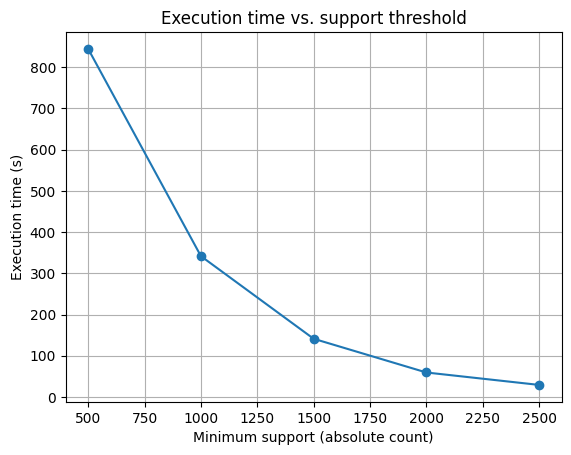

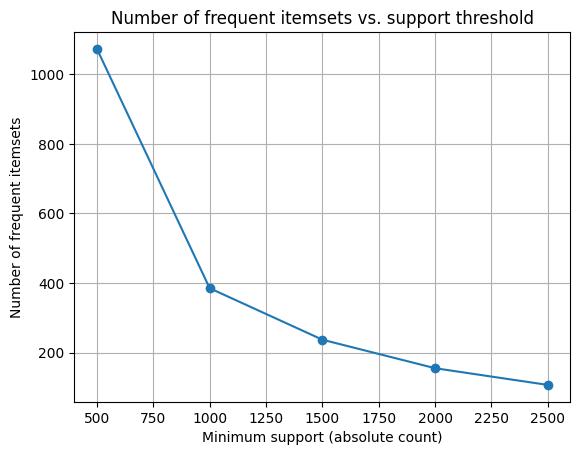

In [7]:
support_values = [500, 1000, 1500, 2000, 2500]
times_support = []
n_itemsets_support = []

for s in support_values:
    start = time.time()
    fi = get_frequent_itemsets(transactions, s)
    end = time.time()

    duration = end - start
    times_support.append(duration)
    n_itemsets_support.append(len(fi))

    print(f"min_support = {s}: {len(fi)} frequent itemsets, time = {duration:.2f} s")

# Plot: time vs support
plt.figure()
plt.plot(support_values, times_support, marker="o")
plt.xlabel("Minimum support (absolute count)")
plt.ylabel("Execution time (s)")
plt.title("Execution time vs. support threshold")
plt.grid(True)
plt.show()

# Plot: number of itemsets vs support
plt.figure()
plt.plot(support_values, n_itemsets_support, marker="o")
plt.xlabel("Minimum support (absolute count)")
plt.ylabel("Number of frequent itemsets")
plt.title("Number of frequent itemsets vs. support threshold")
plt.grid(True)
plt.show()


## 6. Generating Association Rules 

From the set of frequent itemsets, we can derive **association rules** of the form:

\[
X \to Y, \quad X \cap Y = \emptyset
\]

For each frequent itemset \( I \):

- For every non-empty proper subset \( A \subset I \), we can form a rule:
  \[
  A \to I \setminus A
  \]
- The **support** of the rule is the support of \( I \).
- The **confidence** is:
  \[
  \text{conf}(A \to I \setminus A) = \frac{\text{support}(I)}{\text{support}(A)}
  \]

We only keep rules with **confidence ≥ `min_confidence`**.
Since rules are generated from **frequent itemsets**, their support is automatically ≥ `min_support`.


In [8]:
def generate_rules(frequent_itemsets, min_confidence, num_transactions):
    """Generate association rules from frequent itemsets."""
    rules = []
    for itemset, support_count in frequent_itemsets.items():
        if len(itemset) < 2:
            continue
        for consequent_size in range(1, len(itemset)):
            for consequent in itertools.combinations(itemset, consequent_size):
                consequent = frozenset(consequent)
                antecedent = itemset - consequent
                if not antecedent:
                    continue
                support_XY = support_count / num_transactions
                support_X = frequent_itemsets.get(antecedent, 0) / num_transactions
                if support_X > 0:
                    confidence = support_XY / support_X
                    if confidence >= min_confidence:
                        rules.append({
                            "Antecedent": tuple(antecedent),
                            "Consequent": tuple(consequent),
                            "Support": round(support_XY, 4),
                            "Confidence": round(confidence, 4)
                        })
    return pd.DataFrame(rules)

rules_df = generate_rules(frequent_itemsets, min_confidence, len(transactions))
rules_df.head(10)


,Antecedent,Consequent,Support,Confidence
0,"(704,)","(825,)",0.0110,0.6143
1,"(704,)","(39,)",0.0111,0.6171
2,"(825, 39)","(704,)",0.0103,0.8719
3,"(704, 39)","(825,)",0.0103,0.9350
4,"(704, 825)","(39,)",0.0103,0.9392


In [9]:
print("Top 10 Association Rules by Confidence:")
rules_df.sort_values(by="Confidence", ascending=False).head(10)


Top 10 Association Rules by Confidence:


,Antecedent,Consequent,Support,Confidence
4,"(704, 825)","(39,)",0.0103,0.9392
3,"(704, 39)","(825,)",0.0103,0.9350
2,"(825, 39)","(704,)",0.0103,0.8719
1,"(704,)","(39,)",0.0111,0.6171
0,"(704,)","(825,)",0.0110,0.6143


## 7. Effect of the Confidence Threshold

We now study how the **confidence threshold** affects:

- the **number of generated association rules**,
- the **execution time** of the rule generation step.

We fix the support threshold and vary the confidence `c`.


min_confidence = 0.40: 7 rules, time = 0.009 s
min_confidence = 0.50: 7 rules, time = 0.000 s
min_confidence = 0.60: 5 rules, time = 0.001 s
min_confidence = 0.70: 3 rules, time = 0.000 s
min_confidence = 0.80: 3 rules, time = 0.000 s


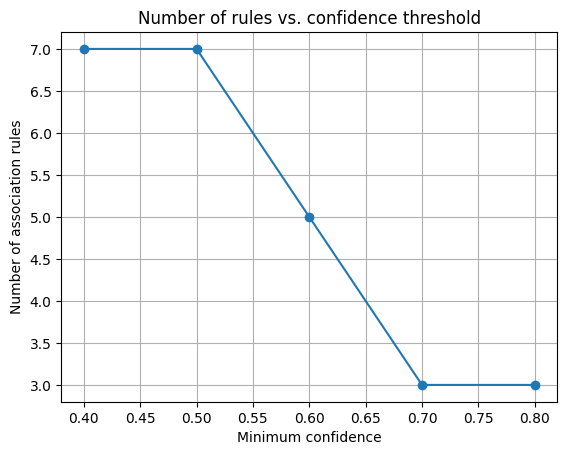

In [11]:
confidence_values = [0.4, 0.5, 0.6, 0.7, 0.8]
times_conf = []
n_rules_conf = []

for c in confidence_values:
    start = time.time()
    rules_c = generate_rules(frequent_itemsets, c, len(transactions))
    end = time.time()

    duration = end - start
    times_conf.append(duration)
    n_rules_conf.append(len(rules_c))

    print(f"min_confidence = {c:.2f}: {len(rules_c)} rules, time = {duration:.3f} s")


# Plot: number of rules vs confidence
plt.figure()
plt.plot(confidence_values, n_rules_conf, marker="o")
plt.xlabel("Minimum confidence")
plt.ylabel("Number of association rules")
plt.title("Number of rules vs. confidence threshold")
plt.grid(True)
plt.show()


### ✅ Conclusions

- The **A-Priori algorithm** efficiently finds frequent itemsets by iteratively expanding candidate sets.  
- Using the **monotonicity property of support**, it avoids unnecessary computations.  
- With reasonable support thresholds (e.g., 0.5% of transactions), the number of candidates remains manageable.
- The **association rules** provide interpretable patterns, e.g., *“if {X, Y}, then Z”*, useful in market basket analysis.

---

### ⚙️ How to Run
1. Upload `T10I4D100K.dat` into the same folder as this notebook (in VS Code or GitHub).  
2. Open the notebook in VS Code or JupyterLab.  
3. Run all cells sequentially (Shift + Enter).  


